
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [ ]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob
  
from collections import defaultdict

base_dir = "/content/project/input"


In [ ]:
os.makedirs('./project/output', exist_ok=True)
%cd project

/content/project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest_X-ray_1024.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/')
# 이름 input으로 변경하기!!!

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/VINDataset/1024/1024_C.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input/')

In [ ]:
# c파일 옮기기

import os
import shutil

def folder_file_copy():
  file_dir = os.path.dirname('/content/project/input/1024_C/')
  print(file_dir)
  file_cnt=1
  for path,dirs,files in os.walk(file_dir):
    for file in files:
      file_path = os.path.join(path,file)
      file_cnt += 1
      dest_path = '/content/project/input/train/'+file
      shutil.copy(file_path,dest_path)

folder_file_copy()

/content/project/input/1024_C


In [ ]:
%pwd

'/content/project'

In [ ]:
df = pd.read_csv('./input/train.csv')

In [ ]:
df1=df
df1

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


In [ ]:
df1['x_min'] = df1['x_min'] / df1['width'] * 1024.0
df1['x_max'] = df1['x_max'] / df1['width'] * 1024.0
df1['y_min'] = df1['y_min'] / df1['height'] * 1024.0
df1['y_max'] = df1['y_max'] / df1['height'] * 1024.0
df1


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340.184615,602.739726,813.784615,802.630137,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,561.777778,264.177778,716.000000,362.311111,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,401.170732,491.419608,874.146341,658.070588,1968,2040


In [ ]:
df=df1
df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340.184615,602.739726,813.784615,802.630137,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,561.777778,264.177778,716.000000,362.311111,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,401.170732,491.419608,874.146341,658.070588,1968,2040


In [ ]:
# nofinding 제거 버전
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,image_id,class_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,4,340.184615,602.739726,813.784615,802.630137
3,051132a778e61a86eb147c7c6f564dfe,1,561.777778,264.177778,716.000000,362.311111
5,1c32170b4af4ce1a3030eb8167753b06,12,252.774803,119.000000,381.782677,144.333333
6,0c7a38f293d5f5e4846aa4ca6db4daf1,6,603.644639,98.191781,980.530416,869.297847
7,47ed17dcb2cbeec15182ed335a8b5a9e,9,222.105919,718.296451,269.158879,758.609007
...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,11,106.666667,551.111111,249.777778,711.466667
67906,26d1d5a0ef2e692c6340e74859ffdc53,14,387.666667,262.333333,446.000000,313.666667
67907,22672ab82c290c20b86863291e25ef6c,6,149.500000,271.974400,397.000000,617.676800
67908,db169d0be36123bd55b866d6aa73983b,10,2.666667,238.222222,120.888889,617.244444


In [ ]:
df['class_id'].value_counts()


1     7162
4     5427
12    4842
14    4655
9     2580
8     2483
11    2476
10    2203
7     1247
6     1000
3      960
5      556
2      279
13     226
Name: class_id, dtype: int64

In [ ]:
dfaugC = pd.read_csv('/content/project/input/dfafter_1024_C.csv')
dfaugC

,image_id,class_id,x_min,y_min,x_max,y_max
0,c394eadea89e5795c8037280492d116d_001_type_1024_C,9,849.600079,186.523550,1024.000000,678.118665
1,c394eadea89e5795c8037280492d116d_001_type_1024_C,9,486.323044,0.000000,709.716384,175.951750
2,c394eadea89e5795c8037280492d116d_001_type_1024_C,9,534.871149,240.304021,920.775508,612.195724
3,c394eadea89e5795c8037280492d116d_001_type_1024_C,9,154.453143,7.404135,402.928228,238.582347
4,c394eadea89e5795c8037280492d116d_001_type_1024_C,9,143.525511,0.000000,768.006510,230.886204
...,...,...,...,...,...,...
72372,dd1ec1034edd4e6b9696ea5cbeca6168_009_type_1024_C,5,127.338896,541.083223,279.087803,666.546896
72373,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,0,457.280890,230.298547,658.663488,355.424042
72374,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,2,592.756456,265.130779,646.051649,342.911493
72375,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,2,604.147795,268.174373,656.629321,355.424042


In [ ]:
dfaugC = dfaugC[dfaugC['class_id'] != 14]
dfaugC['class_id'] = dfaugC['class_id'] + 1
dfaugC = dfaugC[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
dfaugC

,image_id,class_id,x_min,y_min,x_max,y_max
0,c394eadea89e5795c8037280492d116d_001_type_1024_C,10,849.600079,186.523550,1024.000000,678.118665
1,c394eadea89e5795c8037280492d116d_001_type_1024_C,10,486.323044,0.000000,709.716384,175.951750
2,c394eadea89e5795c8037280492d116d_001_type_1024_C,10,534.871149,240.304021,920.775508,612.195724
3,c394eadea89e5795c8037280492d116d_001_type_1024_C,10,154.453143,7.404135,402.928228,238.582347
4,c394eadea89e5795c8037280492d116d_001_type_1024_C,10,143.525511,0.000000,768.006510,230.886204
...,...,...,...,...,...,...
72372,dd1ec1034edd4e6b9696ea5cbeca6168_009_type_1024_C,6,127.338896,541.083223,279.087803,666.546896
72373,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,1,457.280890,230.298547,658.663488,355.424042
72374,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,3,592.756456,265.130779,646.051649,342.911493
72375,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,3,604.147795,268.174373,656.629321,355.424042


In [ ]:
df = pd.concat([df, dfaugC]) 
df

,image_id,class_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,4,340.184615,602.739726,813.784615,802.630137
3,051132a778e61a86eb147c7c6f564dfe,1,561.777778,264.177778,716.000000,362.311111
5,1c32170b4af4ce1a3030eb8167753b06,12,252.774803,119.000000,381.782677,144.333333
6,0c7a38f293d5f5e4846aa4ca6db4daf1,6,603.644639,98.191781,980.530416,869.297847
7,47ed17dcb2cbeec15182ed335a8b5a9e,9,222.105919,718.296451,269.158879,758.609007
...,...,...,...,...,...,...
72372,dd1ec1034edd4e6b9696ea5cbeca6168_009_type_1024_C,6,127.338896,541.083223,279.087803,666.546896
72373,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,1,457.280890,230.298547,658.663488,355.424042
72374,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,3,592.756456,265.130779,646.051649,342.911493
72375,dd1ec1034edd4e6b9696ea5cbeca6168_0010_type_1024_C,3,604.147795,268.174373,656.629321,355.424042


In [ ]:
df['class_id'].value_counts()

14    15554
12    14320
1     13692
6     11000
4      8777
11     7843
8      7413
10     7409
9      6560
7      5256
2      3068
3      2909
13     2486
5      2186
Name: class_id, dtype: int64

In [ ]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    # images
    res['images'].append({
        'id': pic_name,
        'width': 1024,
        'height': 1024,
        'file_name': pic_name+".png"
    })
    
    # annotations
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
# categories    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [ ]:
random.seed(10)

# train_files = glob(os.path.join(base_dir, 'train/*.png'))
# train_files = os.listdir('./input/train')
# train_files = list(map(del_extension, train_files))
train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 2128


(8516, 2128, 10644)

In [ ]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/8516 [00:00<?, ?it/s]

In [ ]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/2128 [00:00<?, ?it/s]

## Environment setting

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

!pip show torch

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


런타임 다시 시작하고 진행합니다.

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 32179, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 32179 (delta 13), reused 27 (delta 2), pack-reused 32112
Receiving objects: 100% (32179/32179), 41.78 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (23140/23140), done.


In [ ]:
%cd ./mmdetection

/content/project/mmdetection


In [ ]:
!pip install openmim
!mim install mmdet==2.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 237 kB 89.0 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 1.3 MB 32.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 728 kB 31.6 MB/s 
Saved /tmp/tmpil6t993m/mmdet-2.22.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.22.0: ['mmcv-full>=1.3.17'].
     |████████████████████████████████| 40.6 MB 9.0 MB/s 
     |████████████████████████████████| 190 kB 91.4 MB/s 
Using cached `mminstall.txt` for mmdet==2.22.0: /

=========

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True
2.25.3
11.3
GCC 9.3


In [ ]:
%pwd

'/content/project/mmdetection'

In [ ]:
!mkdir checkpoints

In [ ]:
%cd /content/project/mmdetection/checkpoints

/content/project/mmdetection/checkpoints


In [ ]:
# Download pretrain weight from mmdetection github (CenterNet R-18 and Retina ResNet-101)
!wget -c https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_2x_coco/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth \
      -O /content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth

--2022-10-29 08:40:49--  https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r101_fpn_2x_coco/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.74.197.92
Connecting to download.openmmlab.com (download.openmmlab.com)|47.74.197.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228377233 (218M) [application/octet-stream]
Saving to: ‘/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth’

/content/project/mm 100%[===================>] 217.80M  9.86MB/s    in 22s     

2022-10-29 08:41:11 (10.1 MB/s) - ‘/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth’ saved [228377233/228377233]



In [ ]:
config = "/content/project/mmdetection/configs/retinanet/retinanet_r101_fpn_2x_coco.py"
checkpoint = "/content/project/mmdetection/checkpoints/retinanet_r101_fpn_2x_coco_20200131-5560aee8.pth"

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [ ]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [83]:
from mmcv import Config
cfg = Config.fromfile(config)

In [84]:
!pip install -q --upgrade wandb
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [85]:
from mmdet.apis import set_random_seed

base_path = '/content/project/input' # base_dir과 같습니다.

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/project/vinBigData/retina/3'

EPOCHS= 30


In [86]:
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"
valid_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"

train_img = "train" # 출력은 "train_100000"
valid_img = 'train'
test_img =  "test" # 출력은 "train_100000"



# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = valid_anno
cfg.data.val.img_prefix = valid_img

#test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img



cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
# 직접 가서 바꿈 !!!!!
cfg.model.bbox_head['num_classes'] = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

cfg.load_from = checkpoint
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = None


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer = dict(type='Adam', lr=0.0003, weight_decay=0.0001)
#cfg.optimizer.lr = 0.02 / 8 # 0.0025
# learning rate
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 5

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'

cfg.log_config = dict(
    interval=10,
    hooks=[
        dict(type='TextLoggerHook'),
        dict(
            type='WandbLoggerHook',
            init_kwargs=dict(
                project='mmdetection',
                name='retina_1024C'))])
            
"""
cfg.model.roi_head.init_cfg =
cfg.model.rpn_head.init_cfg =
cfg.model.neck.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint='torchvision://resnet50'))

cfg.model.backbone.frozen_stage= -1
"""


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='RetinaNet',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_input',
        num_outs=5),
    bbox_head=dict(
        type='RetinaHead',
        num_classes=14,
        in_channels=256,
        stacked_convs=4,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            octave_base_scale=4,
            scales_per_octave=3,
            ratios=[0.5, 1.0, 2.0],
            strides=[8, 16, 32, 64, 128]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [57]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 8516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 10975 | 1 [Atelectasis]         | 2447  | 2 [Calcification] | 2367  | 3 [Cardiomegaly]        | 6999  | 4 [Consolidation] | 1730  |
| 5 [ILD]                | 8847  | 6 [Infiltration]        | 4182  | 7 [Lung Opacity]  | 5817  | 8 [Nodule/Mass]         | 5203  | 9 [Other lesion]  | 5882  |
| 10 [Pleural effusion]  | 6252  | 11 [Pleur

In [58]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


In [59]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# Train
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-29 13:26:20,593 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-29 13:26:20,714 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/retina/3/latest.pth


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


2022-10-29 13:26:21,714 - mmdet - INFO - resumed epoch 20, iter 21300
2022-10-29 13:26:21,718 - mmdet - INFO - Start running, host: root@1dfd105851d8, work_dir: /content/drive/MyDrive/project/vinBigData/retina/3
2022-10-29 13:26:21,721 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) MMDetWandbHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) MMDetWandbHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook          

2022-10-29 13:26:30,545 - mmdet - WARNING - No meta information found in the runner. 


Exception: ignored

In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/retina/model/epoch_{EPOCHS}_retina.pt'
torch.save(model, PATH)

# 학습 이어서 하기

In [87]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/content/drive/MyDrive/project/vinBigData/retina/3/latest.pth'
cfg.load_from = None
EPOCHS = 40
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [ ]:
meta = dict()
meta['exp_name'] = os.path.basename(config)

def train(cfg, meta):
    # Build dataset
    datasets = [mmdet.datasets.build_dataset(cfg.data.train)]


    # Build the detector
    model = mmdet.models.build_detector(
        cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
    model.CLASSES = datasets[0].CLASSES


    # Dump config for logging
    mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
    cfg.dump(os.path.join(cfg.work_dir, meta['exp_name']))


    # Train the model.
    mmdet.apis.train_detector(model, datasets, cfg, distributed=False, validate=True, meta=meta)

train(cfg, meta)

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


2022-10-29 13:39:30,698 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-29 13:39:30,816 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/retina/3/latest.pth


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


2022-10-29 13:39:32,045 - mmdet - INFO - resumed epoch 20, iter 21300
2022-10-29 13:39:32,051 - mmdet - INFO - Start running, host: root@1dfd105851d8, work_dir: /content/drive/MyDrive/project/vinBigData/retina/3
2022-10-29 13:39:32,052 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook          

learning_rate,▁▁▁▁▁▁
momentum,▁▁▁▁▁▁
train/loss,▆█▂▁▅▆
train/loss_bbox,▇█▃▁▆▇
train/loss_cls,▅█▁▁▄▅
learning_rate,3e-05
momentum,0.9
train/loss,0.37697
train/loss_bbox,0.24302
train/loss_cls,0.13396


2022-10-29 13:40:06,208 - mmdet - INFO - Epoch [21][10/1065]	lr: 3.000e-05, eta: 13:27:47, time: 2.277, data_time: 0.280, memory: 12278, loss_cls: 0.1338, loss_bbox: 0.2412, loss: 0.3751
2022-10-29 13:40:26,553 - mmdet - INFO - Epoch [21][20/1065]	lr: 3.000e-05, eta: 12:44:29, time: 2.034, data_time: 0.016, memory: 12278, loss_cls: 0.1471, loss_bbox: 0.2469, loss: 0.3940
2022-10-29 13:40:46,586 - mmdet - INFO - Epoch [21][30/1065]	lr: 3.000e-05, eta: 12:26:08, time: 2.003, data_time: 0.015, memory: 12278, loss_cls: 0.1204, loss_bbox: 0.2280, loss: 0.3485
2022-10-29 13:41:06,496 - mmdet - INFO - Epoch [21][40/1065]	lr: 3.000e-05, eta: 12:15:42, time: 1.991, data_time: 0.015, memory: 12278, loss_cls: 0.1195, loss_bbox: 0.2186, loss: 0.3381
2022-10-29 13:41:26,421 - mmdet - INFO - Epoch [21][50/1065]	lr: 3.000e-05, eta: 12:09:25, time: 1.992, data_time: 0.015, memory: 12278, loss_cls: 0.1297, loss_bbox: 0.2402, loss: 0.3699
2022-10-29 13:41:46,525 - mmdet - INFO - Epoch [21][60/1065]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 238s, ETA:     0s

2022-10-29 14:19:21,948 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.71s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.64s).
Accumulating evaluation results...


2022-10-29 14:19:44,067 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.572
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=5.65s).


2022-10-29 14:19:44,366 - mmdet - INFO - Epoch(val) [21][2128]	bbox_mAP: 0.3000, bbox_mAP_50: 0.5720, bbox_mAP_75: 0.2840, bbox_mAP_s: 0.0390, bbox_mAP_m: 0.3200, bbox_mAP_l: 0.3140, bbox_mAP_copypaste: 0.300 0.572 0.284 0.039 0.320 0.314
2022-10-29 14:20:06,953 - mmdet - INFO - Epoch [22][10/1065]	lr: 3.000e-05, eta: 11:13:58, time: 2.257, data_time: 0.282, memory: 12278, loss_cls: 0.1210, loss_bbox: 0.2328, loss: 0.3538
2022-10-29 14:20:27,240 - mmdet - INFO - Epoch [22][20/1065]	lr: 3.000e-05, eta: 11:13:44, time: 2.029, data_time: 0.016, memory: 12278, loss_cls: 0.1137, loss_bbox: 0.2264, loss: 0.3401
2022-10-29 14:20:47,378 - mmdet - INFO - Epoch [22][30/1065]	lr: 3.000e-05, eta: 11:13:27, time: 2.014, data_time: 0.016, memory: 12278, loss_cls: 0.1161, loss_bbox: 0.2316, loss: 0.3476
2022-10-29 14:21:07,331 - mmdet - INFO - Epoch [22][40/1065]	lr: 3.000e-05, eta: 11:13:06, time: 1.995, data_time: 0.016, memory: 12278, loss_cls: 0.1193, loss_bbox: 0.2273, loss: 0.3466
2022-10-29 14

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 14:59:21,798 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.70s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.21s).
Accumulating evaluation results...


2022-10-29 14:59:43,176 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.577
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=5.01s).


2022-10-29 14:59:43,455 - mmdet - INFO - Epoch(val) [22][2128]	bbox_mAP: 0.3070, bbox_mAP_50: 0.5770, bbox_mAP_75: 0.2990, bbox_mAP_s: 0.0410, bbox_mAP_m: 0.3310, bbox_mAP_l: 0.3200, bbox_mAP_copypaste: 0.307 0.577 0.299 0.041 0.331 0.320
2022-10-29 15:00:06,123 - mmdet - INFO - Epoch [23][10/1065]	lr: 3.000e-06, eta: 10:38:05, time: 2.265, data_time: 0.280, memory: 12278, loss_cls: 0.1382, loss_bbox: 0.2381, loss: 0.3763
2022-10-29 15:00:26,405 - mmdet - INFO - Epoch [23][20/1065]	lr: 3.000e-06, eta: 10:37:48, time: 2.028, data_time: 0.016, memory: 12278, loss_cls: 0.1262, loss_bbox: 0.2333, loss: 0.3595
2022-10-29 15:00:46,448 - mmdet - INFO - Epoch [23][30/1065]	lr: 3.000e-06, eta: 10:37:28, time: 2.004, data_time: 0.016, memory: 12278, loss_cls: 0.1106, loss_bbox: 0.2228, loss: 0.3334
2022-10-29 15:01:06,342 - mmdet - INFO - Epoch [23][40/1065]	lr: 3.000e-06, eta: 10:37:07, time: 1.989, data_time: 0.015, memory: 12278, loss_cls: 0.1290, loss_bbox: 0.2364, loss: 0.3653
2022-10-29 15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 15:39:20,745 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.70s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.50s).
Accumulating evaluation results...


2022-10-29 15:39:41,918 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.89s).


2022-10-29 15:39:42,202 - mmdet - INFO - Epoch(val) [23][2128]	bbox_mAP: 0.3100, bbox_mAP_50: 0.5790, bbox_mAP_75: 0.3030, bbox_mAP_s: 0.0450, bbox_mAP_m: 0.3330, bbox_mAP_l: 0.3240, bbox_mAP_copypaste: 0.310 0.579 0.303 0.045 0.333 0.324
2022-10-29 15:40:04,720 - mmdet - INFO - Epoch [24][10/1065]	lr: 3.000e-06, eta: 10:02:27, time: 2.250, data_time: 0.279, memory: 12278, loss_cls: 0.1113, loss_bbox: 0.2177, loss: 0.3289
2022-10-29 15:40:24,957 - mmdet - INFO - Epoch [24][20/1065]	lr: 3.000e-06, eta: 10:02:09, time: 2.024, data_time: 0.017, memory: 12278, loss_cls: 0.0974, loss_bbox: 0.2090, loss: 0.3064
2022-10-29 15:40:45,172 - mmdet - INFO - Epoch [24][30/1065]	lr: 3.000e-06, eta: 10:01:50, time: 2.022, data_time: 0.016, memory: 12278, loss_cls: 0.1030, loss_bbox: 0.2077, loss: 0.3106
2022-10-29 15:41:05,145 - mmdet - INFO - Epoch [24][40/1065]	lr: 3.000e-06, eta: 10:01:30, time: 1.997, data_time: 0.018, memory: 12278, loss_cls: 0.1022, loss_bbox: 0.2127, loss: 0.3150
2022-10-29 15

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 16:19:21,184 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.07s).
Accumulating evaluation results...


2022-10-29 16:19:41,846 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.86s).


2022-10-29 16:19:42,133 - mmdet - INFO - Epoch(val) [24][2128]	bbox_mAP: 0.3110, bbox_mAP_50: 0.5780, bbox_mAP_75: 0.3020, bbox_mAP_s: 0.0450, bbox_mAP_m: 0.3330, bbox_mAP_l: 0.3250, bbox_mAP_copypaste: 0.311 0.578 0.302 0.045 0.333 0.325
2022-10-29 16:20:04,385 - mmdet - INFO - Epoch [25][10/1065]	lr: 3.000e-06, eta: 9:27:01, time: 2.223, data_time: 0.280, memory: 12278, loss_cls: 0.1170, loss_bbox: 0.2168, loss: 0.3338
2022-10-29 16:20:24,019 - mmdet - INFO - Epoch [25][20/1065]	lr: 3.000e-06, eta: 9:26:39, time: 1.963, data_time: 0.016, memory: 12278, loss_cls: 0.1017, loss_bbox: 0.2103, loss: 0.3120
2022-10-29 16:20:43,728 - mmdet - INFO - Epoch [25][30/1065]	lr: 3.000e-06, eta: 9:26:18, time: 1.971, data_time: 0.017, memory: 12278, loss_cls: 0.1184, loss_bbox: 0.2281, loss: 0.3464
2022-10-29 16:21:03,487 - mmdet - INFO - Epoch [25][40/1065]	lr: 3.000e-06, eta: 9:25:57, time: 1.976, data_time: 0.016, memory: 12278, loss_cls: 0.1089, loss_bbox: 0.2151, loss: 0.3240
2022-10-29 16:21:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 16:59:12,867 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.51s).
Accumulating evaluation results...


2022-10-29 16:59:33,805 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.76s).


2022-10-29 16:59:34,078 - mmdet - INFO - Epoch(val) [25][2128]	bbox_mAP: 0.3120, bbox_mAP_50: 0.5790, bbox_mAP_75: 0.3040, bbox_mAP_s: 0.0420, bbox_mAP_m: 0.3350, bbox_mAP_l: 0.3260, bbox_mAP_copypaste: 0.312 0.579 0.304 0.042 0.335 0.326
2022-10-29 16:59:56,802 - mmdet - INFO - Epoch [26][10/1065]	lr: 3.000e-06, eta: 8:51:02, time: 2.271, data_time: 0.280, memory: 12278, loss_cls: 0.0954, loss_bbox: 0.2003, loss: 0.2957
2022-10-29 17:00:17,165 - mmdet - INFO - Epoch [26][20/1065]	lr: 3.000e-06, eta: 8:50:43, time: 2.036, data_time: 0.015, memory: 12278, loss_cls: 0.1067, loss_bbox: 0.2212, loss: 0.3279
2022-10-29 17:00:37,222 - mmdet - INFO - Epoch [26][30/1065]	lr: 3.000e-06, eta: 8:50:24, time: 2.006, data_time: 0.015, memory: 12278, loss_cls: 0.1092, loss_bbox: 0.2199, loss: 0.3292
2022-10-29 17:00:57,137 - mmdet - INFO - Epoch [26][40/1065]	lr: 3.000e-06, eta: 8:50:03, time: 1.991, data_time: 0.015, memory: 12278, loss_cls: 0.1178, loss_bbox: 0.2168, loss: 0.3346
2022-10-29 17:01:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 238s, ETA:     0s

2022-10-29 17:39:14,491 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.68s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.26s).
Accumulating evaluation results...


2022-10-29 17:39:35,386 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.86s).


2022-10-29 17:39:35,667 - mmdet - INFO - Epoch(val) [26][2128]	bbox_mAP: 0.3130, bbox_mAP_50: 0.5790, bbox_mAP_75: 0.3060, bbox_mAP_s: 0.0410, bbox_mAP_m: 0.3370, bbox_mAP_l: 0.3270, bbox_mAP_copypaste: 0.313 0.579 0.306 0.041 0.337 0.327
2022-10-29 17:39:58,350 - mmdet - INFO - Epoch [27][10/1065]	lr: 3.000e-06, eta: 8:15:46, time: 2.266, data_time: 0.282, memory: 12278, loss_cls: 0.1014, loss_bbox: 0.2132, loss: 0.3146
2022-10-29 17:40:18,609 - mmdet - INFO - Epoch [27][20/1065]	lr: 3.000e-06, eta: 8:15:27, time: 2.026, data_time: 0.016, memory: 12278, loss_cls: 0.0975, loss_bbox: 0.2165, loss: 0.3139
2022-10-29 17:40:38,763 - mmdet - INFO - Epoch [27][30/1065]	lr: 3.000e-06, eta: 8:15:07, time: 2.015, data_time: 0.016, memory: 12278, loss_cls: 0.1120, loss_bbox: 0.2180, loss: 0.3301
2022-10-29 17:40:58,720 - mmdet - INFO - Epoch [27][40/1065]	lr: 3.000e-06, eta: 8:14:47, time: 1.996, data_time: 0.016, memory: 12278, loss_cls: 0.1127, loss_bbox: 0.2176, loss: 0.3303
2022-10-29 17:41:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 18:19:15,672 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.96s).
Accumulating evaluation results...


2022-10-29 18:19:36,100 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.580
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.79s).


2022-10-29 18:19:36,387 - mmdet - INFO - Epoch(val) [27][2128]	bbox_mAP: 0.3130, bbox_mAP_50: 0.5800, bbox_mAP_75: 0.3080, bbox_mAP_s: 0.0400, bbox_mAP_m: 0.3380, bbox_mAP_l: 0.3270, bbox_mAP_copypaste: 0.313 0.580 0.308 0.040 0.338 0.327
2022-10-29 18:19:59,059 - mmdet - INFO - Epoch [28][10/1065]	lr: 3.000e-06, eta: 7:40:26, time: 2.265, data_time: 0.281, memory: 12278, loss_cls: 0.1048, loss_bbox: 0.2109, loss: 0.3157
2022-10-29 18:20:19,356 - mmdet - INFO - Epoch [28][20/1065]	lr: 3.000e-06, eta: 7:40:07, time: 2.030, data_time: 0.016, memory: 12278, loss_cls: 0.1091, loss_bbox: 0.2174, loss: 0.3265
2022-10-29 18:20:39,487 - mmdet - INFO - Epoch [28][30/1065]	lr: 3.000e-06, eta: 7:39:47, time: 2.013, data_time: 0.016, memory: 12278, loss_cls: 0.1131, loss_bbox: 0.2137, loss: 0.3268
2022-10-29 18:20:59,440 - mmdet - INFO - Epoch [28][40/1065]	lr: 3.000e-06, eta: 7:39:27, time: 1.995, data_time: 0.016, memory: 12278, loss_cls: 0.0996, loss_bbox: 0.1979, loss: 0.2975
2022-10-29 18:21:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2128/2128, 9.0 task/s, elapsed: 237s, ETA:     0s

2022-10-29 18:59:15,500 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=14.45s).
Accumulating evaluation results...


2022-10-29 18:59:36,446 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=4.86s).


2022-10-29 18:59:36,724 - mmdet - INFO - Epoch(val) [28][2128]	bbox_mAP: 0.3140, bbox_mAP_50: 0.5790, bbox_mAP_75: 0.3080, bbox_mAP_s: 0.0430, bbox_mAP_m: 0.3380, bbox_mAP_l: 0.3280, bbox_mAP_copypaste: 0.314 0.579 0.308 0.043 0.338 0.328
2022-10-29 18:59:59,402 - mmdet - INFO - Epoch [29][10/1065]	lr: 3.000e-06, eta: 7:05:03, time: 2.266, data_time: 0.282, memory: 12278, loss_cls: 0.1074, loss_bbox: 0.2034, loss: 0.3107
2022-10-29 19:00:19,711 - mmdet - INFO - Epoch [29][20/1065]	lr: 3.000e-06, eta: 7:04:44, time: 2.031, data_time: 0.016, memory: 12278, loss_cls: 0.1006, loss_bbox: 0.2171, loss: 0.3177
2022-10-29 19:00:39,849 - mmdet - INFO - Epoch [29][30/1065]	lr: 3.000e-06, eta: 7:04:24, time: 2.014, data_time: 0.018, memory: 12278, loss_cls: 0.1103, loss_bbox: 0.2282, loss: 0.3384
2022-10-29 19:00:59,763 - mmdet - INFO - Epoch [29][40/1065]	lr: 3.000e-06, eta: 7:04:04, time: 1.991, data_time: 0.016, memory: 12278, loss_cls: 0.0996, loss_bbox: 0.2153, loss: 0.3148
2022-10-29 19:01:

In [ ]:
"""from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)
"""

In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/retina/model/epoch_{EPOCHS}_3_retina.pt'
torch.save(model, PATH)

## Test the trained detector

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [ ]:
len(test_file), test_file[0]

(3000, '/content/project/input/test/b9dcec0d41bcd2acb499745d5aeeaf08.png')

In [ ]:
model = torch.load('/content/drive/MyDrive/project/vinBigData/retina/1/epoch_20.pth')

테스트 데이터 하나를 추론해봅니다.

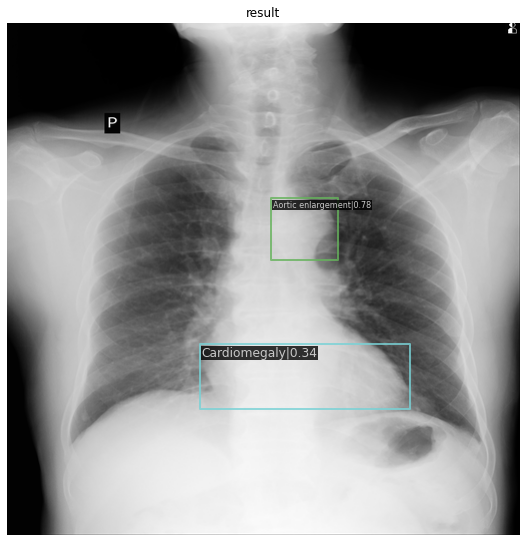

In [ ]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


In [ ]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (6, 5), (0, 5), (6, 5), (3, 5), (0, 5))

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [ ]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [ ]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

In [ ]:
submission.head()

In [ ]:
submission.to_csv(f'/content/drive/MyDrive/project/vinBigData/submission/retina/mmdedtection_colab_retina_{EPOCHS}_1.csv', index=False)